In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys, os
sys.path.append('../')
from data_handling import Container,load_data,Normalize,Denormalize
from plot_style.style_prab import load_preset,figsize
from plot_style.style_prab import colors as colors_preset
from train_ensemble import train, NN, Loss
from analysis.scan_model import median,quantile
load_preset(scale=1,font_path='../plot_style/font')


matplotlib preset loaded


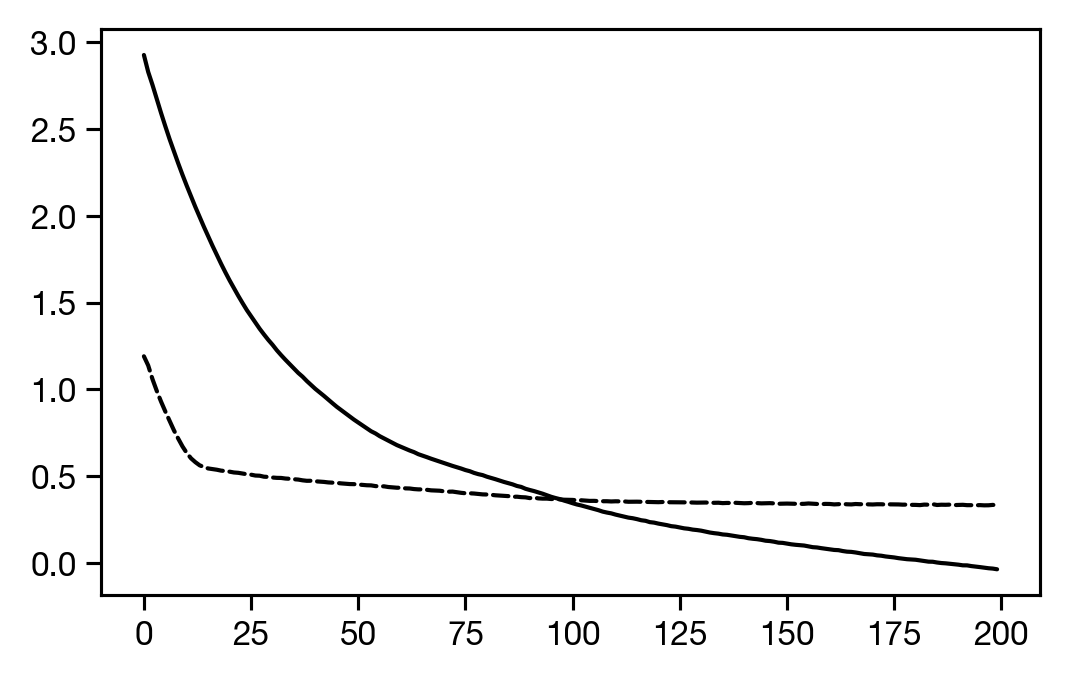

In [48]:
import re

fp = './logs/models/selected_inputs/ensamble_net.log-2024_02_28_13_07.log'
loss = []
OD_loss = []
with open(fp) as file:
    for line in file:
        l = re.search(r'(?<=MSE-Loss: )\d+.\d+', line)
        #l = re.search('(?<=Validation Loss: )\d+.\d+', line)
        l1 = re.search(r'(?<=OD-Loss: )\d+.\d+', line)
        if l:
            loss.append(float(l.group(0)))
        if l1:
            OD_loss.append(float(l1.group(0)))
plt.plot(np.log(loss),'k--')
plt.plot(np.log(OD_loss),'k')


In [49]:
import pickle
from ensemble.Bregressor_ import BaggingRegressor
from ensemble.utils import io

model_path = './models/selected_inputs/'
with open(f'{model_path}config.pkl', 'rb') as fp:
    config = pickle.load(fp)
    norm = config['norm']


if isinstance(config['model'],list):
    model = nn.ModuleList(config['model'])
    #model = config['model']

    ensemble = BaggingRegressor(estimator=model,               # estimator is your pytorch model
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io.load(ensemble, model_path)
else:
    model = config['model']
    ensemble = BaggingRegressor_te(estimator=model,               # estimator is your pytorch model
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io_te.load(ensemble, model_path)
    
    
path='../data/dataframe_combined_espec_interpolated_gaia_energy_2022.h5'
trainset, testset, _ = load_data(
config["path"],
config["inputs"],
config["outputs"],
samples=config['samples'],
ratio=config['ratio'],
start_ind=0,
norm=norm,
random=False,
)

trainset = Container(trainset)
testset = Container(testset)

testset.x = testset.x.to('cpu')
testset.y = testset.y.to('cpu')

In [52]:
from sklearn.metrics import r2_score

y_pred = median(testset.x,ensemble).detach().numpy()
y = testset.y.detach().numpy()
r2_score(y,y_pred)

0.4829598895886262

In [53]:
0.4829598895886262-0.5170961676909055

-0.034136278102279316

In [54]:
x = testset.x.clone().to('cpu')
y = testset.y.clone().to('cpu')
my = median(x,ensemble).detach().numpy()
loss_org = r2_score(y,my,multioutput='raw_values')

fimpp =  []

for e in ensemble:
    fimp = []

    for i, inp in enumerate(config['inputs']):
        x = testset.x.clone().to('cpu')
        y = testset.y.clone().to('cpu')
        x[:,i] = x[torch.randperm(x.size()[0]),i]
        my = median(x,[e]).detach().numpy()
        fimp.append(r2_score(y,my,multioutput='raw_values'))
    fimpp.append(fimp)

fimp = np.abs(np.array(fimpp)-loss_org)

/tmp/ipykernel_9356/2643108102.py:128: UserWarning: The figure layout has changed to tight
  fig_bar.tight_layout()


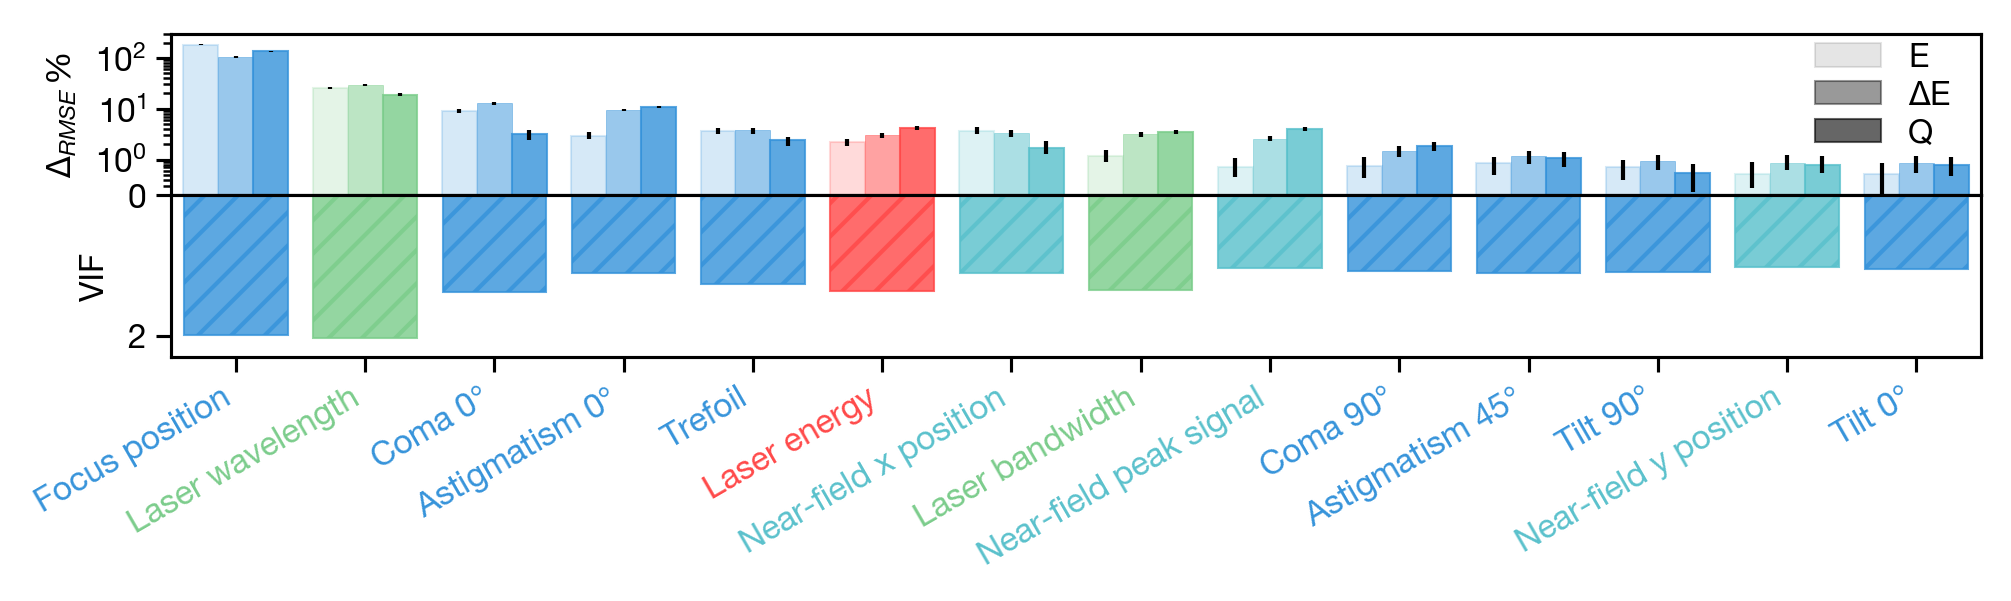

In [55]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib
import matplotlib.patches as mpatches


nice_labels = ['Laser energy',
               'Near-field x position',
               'Near-field y position',
               'Near-field peak signal',
               'Laser wavelength',
               'Laser bandwidth',
               r'Tilt 0$\degree$',
               r'Tilt 90$\degree$',
               'Focus position',
               r'Astigmatism 0$\degree$',
               r'Astigmatism 45$\degree$',
               r'Coma 0$\degree$',
               r'Coma 90$\degree$',
               'Trefoil']

color_groups = [['Laser energy',],
                ['Near-field x position',
                 'Near-field y position',
                 'Near-field peak signal',],
                ['Laser wavelength',
                 'Laser bandwidth',],
                [r'Tilt 0$\degree$',
                 r'Tilt 90$\degree$',
                 'Focus position',
                 r'Astigmatism 0$\degree$',
                 r'Astigmatism 45$\degree$',
                 r'Coma 0$\degree$',
                 r'Coma 90$\degree$',
                 'Trefoil']]

colors = colors_preset


order = np.argsort(fimp.mean(0).mean(-1))[::-1]
ordered_labels = [config['inputs'][i] for i in order]

ordered_nice_labels = [nice_labels[i] for i in order]

df = pd.DataFrame(testset.x.detach().numpy(),columns=config['inputs'])

df = df[ordered_labels]



vif = pd.DataFrame()
vif['labels'] = df.columns
vif = vif.set_index('labels')
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

df_stats = pd.DataFrame()
df_stats['labels'] = ordered_labels
df_stats['importance_med'] = fimp.mean(0)[:,0][order]
df_stats['importance_mad'] = fimp.mean(0)[:,1][order]
df_stats['importance_q'] = fimp.mean(0)[:,2][order]

q = 0.95
c_med = np.dstack((np.quantile(fimp[:,:,0],q,axis=0)[order]-df_stats['importance_med'],
                   df_stats['importance_med']-np.quantile(fimp[:,:,0],1-q,axis=0)[order]))[0].T
c_mad = np.dstack((np.quantile(fimp[:,:,1],q,axis=0)[order]-df_stats['importance_mad'],
                   df_stats['importance_mad']-np.quantile(fimp[:,:,1],1-q,axis=0)[order]))[0].T
c_q = np.dstack((np.quantile(fimp[:,:,2],q,axis=0)[order]-df_stats['importance_q'],
                   df_stats['importance_q']-np.quantile(fimp[:,:,2],1-q,axis=0)[order]))[0].T

df_stats = df_stats.set_index('labels')
df_stats = df_stats.join(vif)
df_stats['ticks'] = ordered_nice_labels

fig_w = figsize['inch']['column_width']
fig_bar,ax = plt.subplots(2,1,figsize=(fig_w*2,fig_w*0.6),sharex=True)

ticks = np.arange(14)
ticklabels = df_stats['ticks']

width = 0.27
b10 = ax[0].bar(ticks-width,df_stats['importance_med']*100,yerr=c_med*100,width=width,alpha=0.2,lw=0.5,)
b11 = ax[0].bar(ticks,df_stats['importance_mad']*100,yerr=c_med*100,width=width,alpha=0.5,lw=0.2,)
b12 = ax[0].bar(ticks+width,df_stats['importance_q']*100,yerr=c_med*100,width=width,alpha=0.8,lw=0.5)
b1 = [b10,b11,b12]

b2 = ax[1].bar(df_stats['ticks'],df_stats['VIF'],alpha=0.8,hatch='///',lw=0.5)


for j,b in enumerate(b2):
    
    jj = 0
    
    for g in color_groups:
        if ordered_nice_labels[j] in g:
            break
        else:
            jj += 1
    
    c = colors[jj]
    b.set_color(c)
    #b.set_edgecolor(None)

    for bb in b1:
        bb[j].set_color(c)
        #bb[j].set_edgecolor(None)
    ax[1].get_xticklabels()[j].set_color(c)
    ax[1].get_xticklabels()[j].set_alpha(0.99)


ax[0].tick_params(axis='x', 
                  bottom=False,
                  direction='in') # labels along the bottom edge are off
 


ax[1].set_ylim(0,2.3)
ax[0].set_xlim(-1/2,df_stats.shape[0]-1/2)
ax[0].set_yscale('log')
ax[0].set_ylim(0.2,300)


ax[1].invert_yaxis()
ax[0].set_ylabel(r'$\Delta_{RMSE}\,$%')
ax[1].set_ylabel('VIF')
    
plt.xticks(rotation=30,ha='right')
fig_bar.tight_layout()

fig_bar.subplots_adjust(hspace=0,wspace=0)


patches = [mpatches.Patch(color='k', alpha=0.1, label='E',lw=0.5),
           mpatches.Patch(color='k', alpha=0.4, label=r'$\Delta$E',lw=0.5),
           mpatches.Patch(color='k', alpha=0.6, label='Q',lw=0.5)]
ax[0].legend(handles=patches,frameon=False,labelspacing=0.2,bbox_to_anchor=(0.5, .1, 0.5, 0.5))

plt.savefig('figures/importance.png')